In [82]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
import pandas as pd
import json
from datetime import datetime
from pandas.tseries.offsets import BDay
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

In [83]:
# 1. loading fine tuned OPT and tokenizer
model_path = r"opt-finetuned"

model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-2.7b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [84]:
# 2. the headline
headline = "Google, Meta face penalties for anti-competitive behaviour towards South African news media."

In [85]:
# 3. tokenize the headline
inputs = tokenizer(
    headline,
    padding='max_length',
    truncation=True,
    max_length=128,
    return_tensors="pt"
)

In [86]:
# 4. eval_mode and then inference
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    predicted_class = torch.argmax(probabilities).item()

In [87]:
# 5. print results
class_labels = {0: "We Down", 1: "We Up"}
print(f"Input: {headline}")
print(f"Predicted class: {predicted_class} ({class_labels[predicted_class]})")
print(f"Class probabilities: {probabilities.tolist()[0]}")
print(predicted_class)

Input: Google, Meta face penalties for anti-competitive behaviour towards South African news media.
Predicted class: 1 (We Up)
Class probabilities: [0.018076976761221886, 0.9819230437278748]
1


In [88]:
def predict_movement(headline):
    inputs = tokenizer(headline, return_tensors="pt",
                       padding=True, truncation=True)
    outputs = model(**inputs)
    probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
    predicted_class = torch.argmax(probabilities, dim=-1).item()
    return predicted_class, probabilities

In [89]:
def long_short_strategy(predicted_class, current_price, portfolio, position, shares):
    if predicted_class == 1:
        #print("Long the stock")
        if position == "short":
            # Close short position
            portfolio += shares * current_price
            shares = 0
            position = "none"
        if position == "none":
            # Open long position
            amount_to_invest = min(0.2 * portfolio, portfolio)
            shares = amount_to_invest // current_price
            portfolio -= shares * current_price
            position = "long"
    else:
        #print("Short the stock")
        if position == "long":
            # Close long position
            portfolio += shares * current_price
            shares = 0
            position = "none"
        if position == "none":
            # Open short position
            amount_to_invest = min(0.2 * portfolio, portfolio)
            shares = amount_to_invest // current_price
            portfolio += shares * current_price
            position = "short"

    return portfolio, position, shares

In [91]:
# testing !

# get stock returns data
goog = pd.read_csv("stock_returns.csv")

# get the news data
with open("test_data.json", "r") as json_file:
    google_news = json.load(json_file)

# init portfolio with 10k
portfolio = 10000
position = "none"
shares = 0

news_by_date = defaultdict(list)
for news_item in google_news:
    news_date = news_item['date']
    news_by_date[news_date].append(news_item['headline'])

In [92]:
portfolio_data = defaultdict()
goog_data = defaultdict()
buy_data = defaultdict()
sell_data = defaultdict()

In [93]:

# go through the news data
for news_date, headlines in news_by_date.items():
    # Convert news_date to datetime object
    news_date_dt = datetime.strptime(news_date, '%Y-%m-%d')

    # Find the next business day for the opening price
    next_business_day = news_date_dt
    while next_business_day.strftime('%Y-%m-%d') not in goog['Date'].values:
        next_business_day += BDay(1)
    next_business_day_str = next_business_day.strftime('%Y-%m-%d')

    # Get the opening price on the next business day
    try:
        current_price = goog.loc[goog['Date'] ==
                                 next_business_day_str, 'Open'].values[0]
        print(f"Opening price on {next_business_day_str}: {current_price}")
    except IndexError:
        # If the date is not found in the stock data, skip this news item
        print(
            f"Skipping news item on {news_date} - opening price not found for {next_business_day_str}")
        continue

    # get predictions for each headline
    predictions = [predict_movement(headline)[0] for headline in headlines]
    # find the majority prediction
    majority_prediction = max(set(predictions), key=predictions.count)
    print(
        f"Majority prediction for date {news_date_dt} is: {majority_prediction}")

    # Apply the long-short strategy based on the majority prediction
    portfolio, position, shares = long_short_strategy(
        majority_prediction, current_price, portfolio, position, shares)
    #print(f"Current portfolio price: {portfolio}")
    portfolio_data[news_date] = portfolio
    goog_data[news_date] = current_price
    if position == 'long':
        buy_data[news_date] = position
    if position == 'short':
        sell_data[news_date] = position
    

print(f"Final portfolio value: {portfolio}")

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Opening price on 2024-09-30: 164.59327657551455
Majority prediction for date 2024-09-30 00:00:00 is: 0
Opening price on 2024-09-30: 164.59327657551455
Majority prediction for date 2024-09-29 00:00:00 is: 1
Opening price on 2024-09-30: 164.59327657551455
Majority prediction for date 2024-09-28 00:00:00 is: 0
Opening price on 2024-09-27: 163.7242657889928
Majority prediction for date 2024-09-27 00:00:00 is: 0
Opening price on 2024-09-26: 164.84298524503637
Majority prediction for date 2024-09-26 00:00:00 is: 0
Opening price on 2024-09-25: 162.78531624884735
Majority prediction for date 2024-09-25 00:00:00 is: 0
Opening price on 2024-09-24: 164.06386867184287
Majority prediction for date 2024-09-24 00:00:00 is: 0
Opening price on 2024-10-31: 174.5220068368585
Majority prediction for date 2024-10-31 00:00:00 is: 0
Opening price on 2024-10-30: 182.2032983314778
Majority prediction for date 2024-10-30 00:00:00 is: 0
Opening price on 2024-10-29: 169.19304410385806
Majority prediction for date

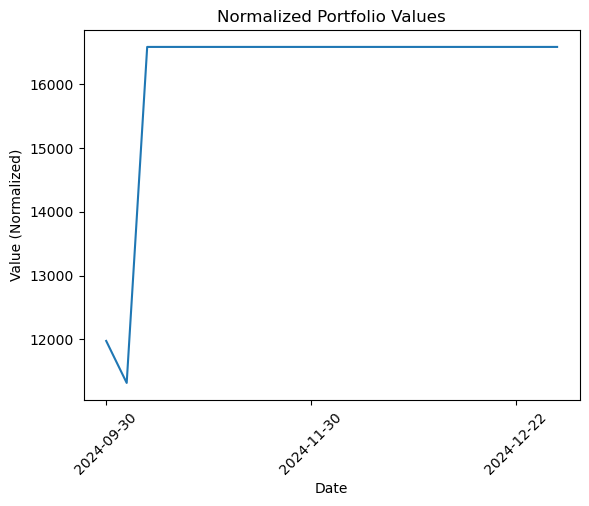

In [98]:


x = list(portfolio_data.keys())
y = list(portfolio_data.values())

fig, ax = plt.subplots()
ax.plot(x, y)

# Show every 2nd tick only
ax.set_xticks(x[::10])
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Value (Normalized)")
plt.title("Normalized Portfolio Values")
plt.show()

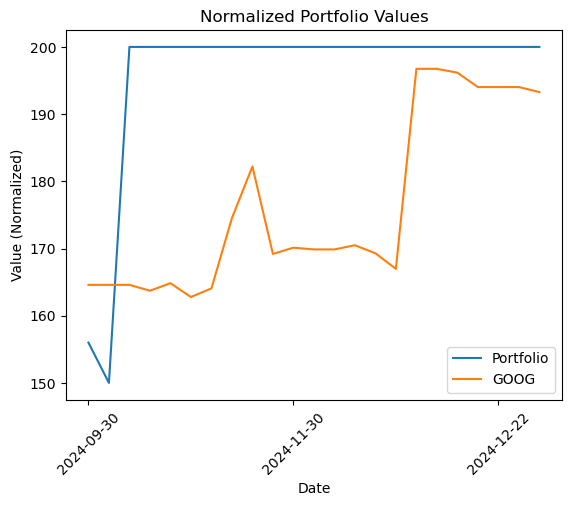

In [99]:
port_norm_data = defaultdict()
min_val = min(portfolio_data.values())
max_val = max(portfolio_data.values())
for key, val in portfolio_data.items():
    val = (150 + (val - min_val) / (max_val - min_val) * (200 - 150)).astype(int)
    port_norm_data[key] = val

x = list(port_norm_data.keys())
y = list(port_norm_data.values())
goog = list(goog_data.values())

fig, ax = plt.subplots()
ax.plot(x, y, label='Portfolio')
ax.plot(x, goog, label = 'GOOG')

ax.set_xticks(x[::10])
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Value (Normalized)")
plt.title("Normalized Portfolio Values")
plt.legend()
plt.show()

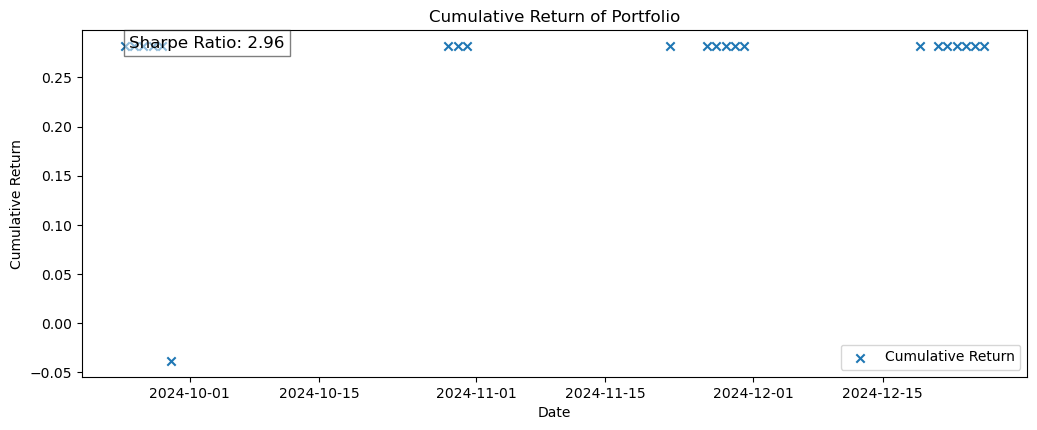

In [100]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Example portfolio data (replace with your actual data)

# Convert the portfolio data to a DataFrame
portfolio_df = pd.DataFrame(list(port_norm_data.items()), columns=[
                            'Date', 'Portfolio Value'])
portfolio_df['Date'] = pd.to_datetime(portfolio_df['Date'])
portfolio_df.set_index('Date', inplace=True)

# Calculate daily returns
portfolio_df['Daily Return'] = portfolio_df['Portfolio Value'].pct_change()

# Calculate the Sharpe ratio
risk_free_rate = 0.0  # Assuming a risk-free rate of 0 for simplicity
portfolio_df['Excess Return'] = portfolio_df['Daily Return'] - risk_free_rate
sharpe_ratio = portfolio_df['Excess Return'].mean(
) / portfolio_df['Excess Return'].std() * np.sqrt(252)

# Plot the cumulative returns of the portfolio
portfolio_df['Cumulative Return'] = (
    1 + portfolio_df['Daily Return']).cumprod() - 1

plt.figure(figsize=(12.2, 4.5))
plt.scatter(portfolio_df.index,
         portfolio_df['Cumulative Return'], label='Cumulative Return', marker='x')
plt.title("Cumulative Return of Portfolio")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()

# Annotate the plot with the Sharpe ratio
plt.annotate(f'Sharpe Ratio: {sharpe_ratio:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=12,
             bbox=dict(facecolor='white', alpha=0.5))

plt.show()

Some weights of OPTForSequenceClassification were not initialized from the model checkpoint at facebook/opt-2.7b and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


F1 Score: 0.59


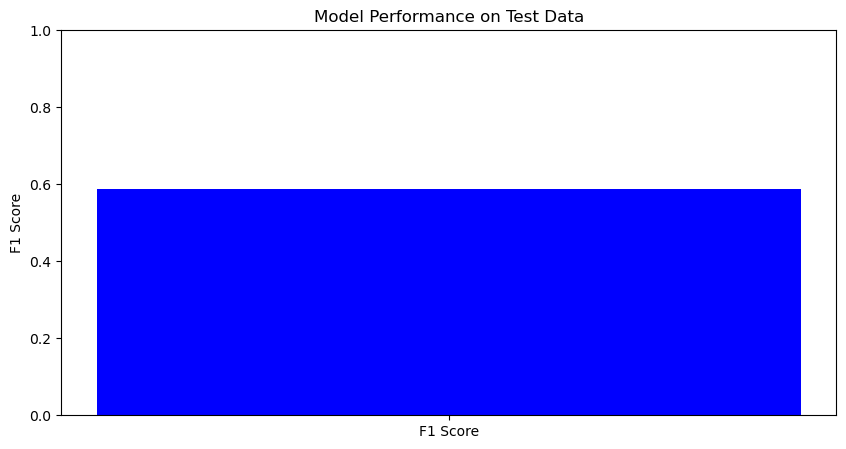

In [103]:
import json
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pandas as pd

# Load the fine-tuned model and tokenizer
model_name = "opt-finetuned"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=2)

# Load the test data
with open("test_data.json", "r") as json_file:
    test_data = json.load(json_file)

# Prepare the test data
test_headlines = [item['headline'] for item in test_data]
true_labels = [item['label'] for item in test_data]

# Tokenize the test data
inputs = tokenizer(test_headlines, return_tensors="pt",
                   padding=True, truncation=True)

# Make predictions
with torch.no_grad():
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1).tolist()

# Calculate the F1 score
f1 = f1_score(true_labels, predictions, average='weighted')
print(f"F1 Score: {f1:.2f}")

# Plot the F1 score
plt.figure(figsize=(10, 5))
plt.bar(['F1 Score'], [f1], color='blue')
plt.title('Model Performance on Test Data')
plt.ylabel('F1 Score')
plt.ylim(0, 1)
plt.show()

In [ ]:
import statsmodels.api as sm
from statsmodels.stats.cluster import clogit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

stock_data_train = pd.read_csv('stock_returns_training.csv')
stock_data_train = stock_data_train.dropna()

stock_data_test = pd.read_csv('stock_returns.csv')
stock_data_test = stock_data_test.dropna()

#sentiments
merged = pd.merge(stock_data_test, predicted_class, on= 'Date', how='inner')

#Create a column for the subsequent day's return (assuming stock_data has 'Return' for daily returns)
merged['Next Day Return'] = merged.groupby('Stock_ID')['Close'].shift(-1)  # 'Stock_ID' is assumed to be the identifier

# Feature matrix X and target variable y
# Assuming 'Sentiment Label' and 'Probability' columns represent the language model scores (from your models)
X = merged[['Sentiment Label', 'Probability']]  # You can include more language model features if needed
y = merged['Next Day Return']  # The subsequent day's return

# Adding fixed effects columns for 'Firm' and 'Date'
merged['Firm'] = merged['Stock_ID']
merged['Date'] = pd.to_datetime(merged['Date'])

# Add constant term for intercept
X = sm.add_constant(X)

# Double clustering by firm and date
model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': [merged['Firm'], merged['Date']]})

# Print the regression results
print(model.summary())

# Predict using the regression model
y_pred = model.predict(X)

# Evaluate the model (Mean Squared Error and R-squared)
mse = mean_squared_error(y, y_pred)
print(f'Mean Squared Error: {mse}')

ModuleNotFoundError: No module named 'statsmodels.stats.cluster'